<a href="https://colab.research.google.com/github/GeorgeWilliam1999/XAI-Project/blob/main/Quantum_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NEXT STEP
(to be updated every session)

Try other circuits

Run lime using binary Quantum classifier

Develope interpretable method based on the distance between the expectation value and the decision boundaries.

Think model agnostic. The VQC outputs an expectation value. Use LIME or other to examine its potential landscape.

In [ ]:
!pip install qulacs
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [ ]:
import qulacs
import numpy as np
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd 


# QML
## Parameterised quantum circuit set up

Starting goal circuit:
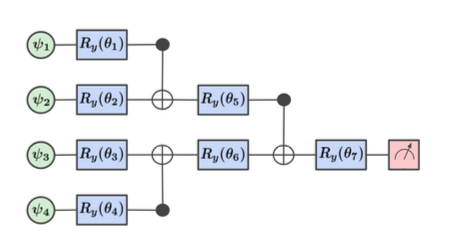

This circuit is able to perform binary classification of data. The anzats is convolutional which helps avoid the barren plat. which can prevent the variational circuit from being optermised

## Iris data processing

In [ ]:
#Load and view iris data set
iris = load_iris()
iris.DESCR

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

In [ ]:
iris.data.shape,iris.target.shape

((150, 4), (150,))

In [ ]:
#Load iris data and classification to the same array.
features = iris.feature_names
features.append('label')
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target

In [ ]:
iris_df = pd.DataFrame(data = data, columns = features)

In [ ]:
iris_df.head(100)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1.0
96,5.7,2.9,4.2,1.3,1.0
97,6.2,2.9,4.3,1.3,1.0
98,5.1,2.5,3.0,1.1,1.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
train_data[:,0:4] = X_train
train_data[:,4] = y_train
train_df = pd.DataFrame(data = train_data, columns = features)

test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
test_data[:,0:4] = X_test
test_data[:,4] = y_test
test_df = pd.DataFrame(data = test_data, columns = features)

Featurewise pair plots:

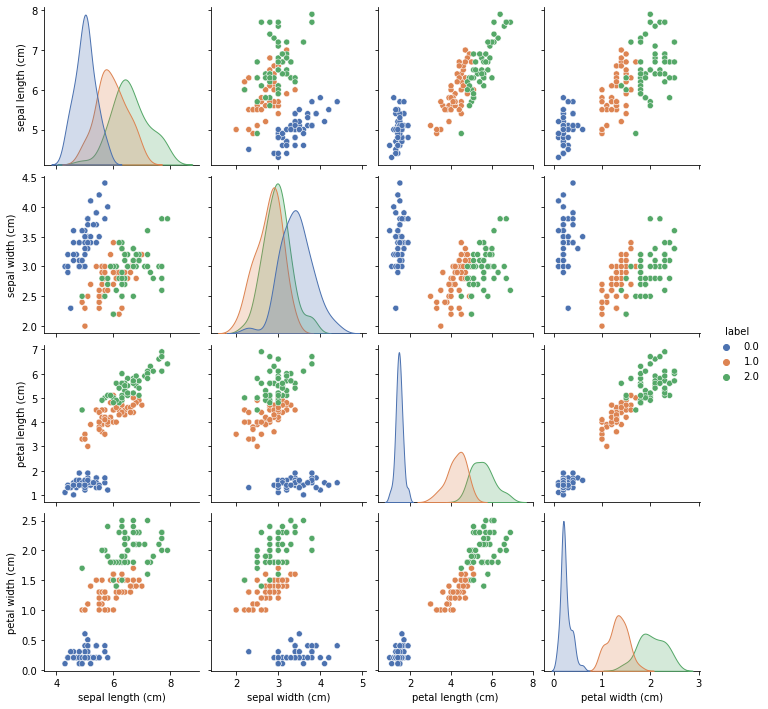

In [ ]:
sns.pairplot(iris_df, hue="label", palette = 'deep')

## Data preprocessing, embedding and computational circuit

The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.

Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.

To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.

But first, the data will need normalising as described above.

### Preprocessing

Test train split:

In [ ]:
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  min_values = np.zeros(dim)

  for i in range(dim):
    min_values[i] = np.amin(data[:,i])
    data[:,i] = data[:,i] - min_values[i]

  largest_values = np.zeros(dim)
  
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])


  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))

  for i in range(dim):

    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

Rescaled to be between 0 and pi/2 using pandas dataframe functions

In [ ]:
train_df[train_df.columns[:4]] -= train_df[train_df.columns[:4]].min()
train_df[train_df.columns[:4]] /= train_df[train_df.columns[:4]].max()
train_df[train_df.columns[:4]] *= np.pi/2

In [ ]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,0.646798,0.642598,0.869548,0.785398,1.0
1,1.524596,0.713998,1.542746,1.308997,2.0
2,0.600599,0.713998,0.953698,0.916298,1.0
3,0.369599,1.070997,0.084150,0.065450,0.0
4,1.570796,0.571199,1.570796,1.243547,2.0


In [ ]:
test_df[test_df.columns[:4]] -= test_df[test_df.columns[:4]].min()
test_df[test_df.columns[:4]] /= test_df[test_df.columns[:4]].max()
test_df[test_df.columns[:4]] *= np.pi/2

In [ ]:
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,0.762958,0.428399,0.985076,0.719948,1.0
1,0.583439,1.142397,0.186366,0.130900,0.0
2,1.481037,0.285599,1.570796,1.439897,2.0
3,0.718078,0.499799,0.931828,0.916298,1.0
4,1.077117,0.428399,1.011699,0.850848,1.0


In [ ]:
#normed_train_data = half_pi_norm(X_train)
#normed_test_data = half_pi_norm(X_test)

### Embedding circuit (Qubit Embedding)

Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

In [ ]:
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

### Computational Circuit 

To build two qubit gates one needs to use combinations of single qubit gates and control operations.

I am copy the state after each operation for comparison.

Now its time for a parameterised quantum circuit.

Each two qubit unitary will be specified by two angles

In [ ]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U_dom():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

### Mixed embedding and computational circuit

## Get expectation

The below function will return the expectation scaled between 2 and 0.

In [ ]:
def get_expectation(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)

  return exp + 1

# Trinary Clasification

In [ ]:
from qulacs import Observable

## prepare circuit data

In [ ]:
circuit = U_dom()
theta_0 = np.random.rand(7)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

In [ ]:
circuit.get_parameter

<bound method PyCapsule.get_parameter of *** Quantum Circuit Info ***
# of qubit: 4
# of step : 5
# of gate : 10
# of 1 qubit gate: 7
# of 2 qubit gate: 3
Clifford  : no
Gaussian  : no

*** Parameter Info ***
# of parameter: 7
>

In [ ]:
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

In [ ]:
param

[0.3133253270309575,
 0.022670806446040692,
 0.7760623477334141,
 0.749392886526846,
 0.5773474479652623,
 0.9848732152582855,
 0.5372711717261189]

NOTE TO SELF

use pca on the components to see what the most important eigen vlaues/vectors are doing.

In [ ]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,0.646798,0.642598,0.869548,0.785398,1.0
1,1.524596,0.713998,1.542746,1.308997,2.0
2,0.600599,0.713998,0.953698,0.916298,1.0
3,0.369599,1.070997,0.084150,0.065450,0.0
4,1.570796,0.571199,1.570796,1.243547,2.0


## Define operators and make initial predictions
Initatial expectation and classification is prior to training.

I will use the Pauli Z operator to take the expectation of the unitary evolution of embedded data points.

In [ ]:
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [ ]:
#Classify and expectation value that is reshaped to be between 0 and 2.
def classify_tri(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

Below I visualise the naive predictions on the training data. Clearly the predictions are sub optimal.

In [ ]:
expectation = []
for i in range(len(train_df)):
  expectation.append(get_expectation(train_df.iloc[i][0:4],U_dom,np.random.rand(7)))
train_df.insert(4,'Expectation', expectation)


Bellow are the charts of the true classifications

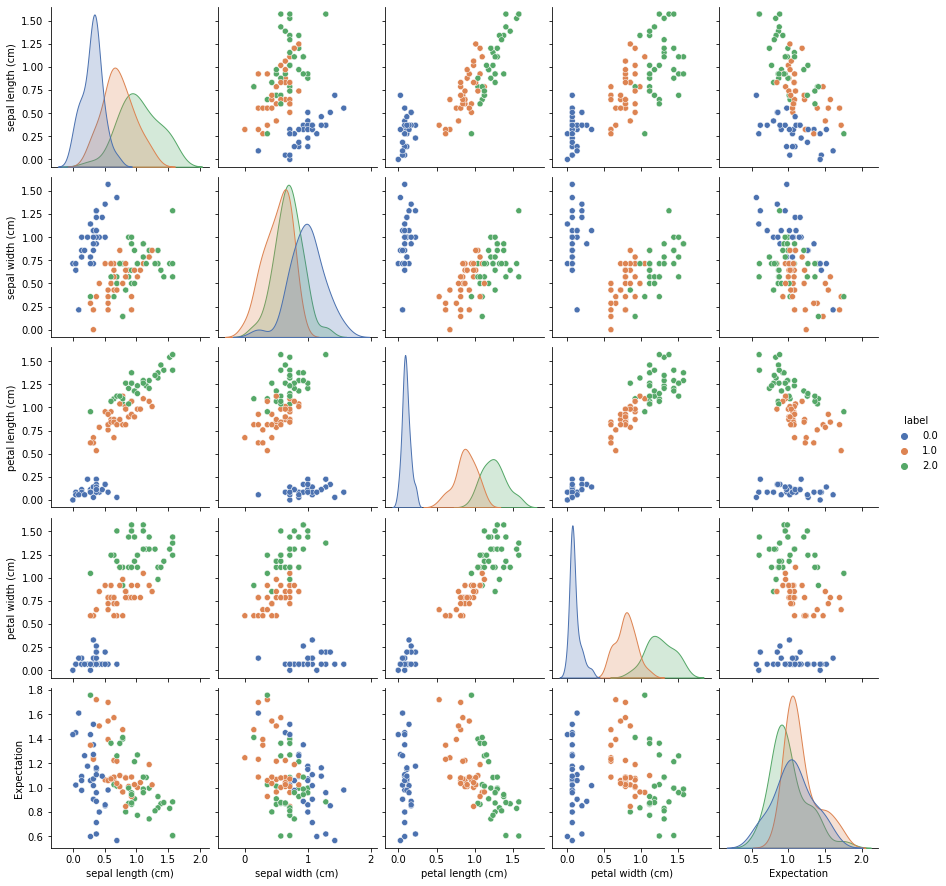

In [ ]:
sns.pairplot(train_df, hue="label", palette = 'deep')

Naive expectation values with random angle, very poor but thats expected.

In [ ]:
def cost_train(theta):
  #get predictions
  expect = np.zeros(len(train_df))
  for i in range(len(train_df)):
    expect[i] = get_expectation(train_df.iloc[i][0:4],U_dom, theta)
  #Simple MSE example
  
  #Sxpectation values
  L = ((expect - y_train)**2).mean()

  return L

In [ ]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation,label
0,0.646798,0.642598,0.869548,0.785398,1.222066,1.0
1,1.524596,0.713998,1.542746,1.308997,0.828452,2.0
2,0.600599,0.713998,0.953698,0.916298,1.074204,1.0
3,0.369599,1.070997,0.084150,0.065450,0.712250,0.0
4,1.570796,0.571199,1.570796,1.243547,0.601867,2.0


In [ ]:
cost_train(np.random.rand(7))

0.3789528870482013

In [ ]:
#find number of correct predictions
correct = 0
for i in range(len(y_train)):
  if y_train[i] == classify_tri(train_df['Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')


The initial calssification is 56.99999999999999 % accurate


## Optimise
The updated parameters are generated and tested below:

In [ ]:
from scipy.optimize import minimize #BFGS works well/cobyla

In [ ]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(7)
result = minimize(cost_train, theta_0, method='cobyla')
theta = result.x

In [ ]:
theta, theta_0

(array([ 0.31818094,  1.57187468,  0.48219713,  0.81347406, -0.110955  ,
         0.55399254,  0.6309944 ]),
 array([0.87091674, 0.61877386, 0.45425604, 0.92429277, 0.0340692 ,
        0.69317383, 0.74026308]))

In [ ]:
cost_train(theta),cost_train(theta_0)

(0.079343699007767, 0.33176704769978715)

## Reclasify

In [ ]:
def cost_test(theta):
  #get predictions
  expect = np.zeros(len(test_df))
  for i in range(len(test_df)):
    expect[i] = get_expectation(test_df.iloc[i][0:4],U_dom,theta)
  #Simple MSE example
  L = ((expect - y_test)**2).mean()
  return L

In [ ]:
cost_test(theta),cost_test(theta_0)

(0.0809464596447204, 0.41829869828286514)

In [ ]:
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_dom, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_dom, theta)

test_df.insert(4,'Expectation Values', expectations)
test_df.insert(5,'Quantum Prediction', better_predictions)

In [ ]:
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation Values,Quantum Prediction,label
0,0.762958,0.428399,0.985076,0.719948,0.804159,1.0,1.0
1,0.583439,1.142397,0.186366,0.130900,0.435441,0.0,0.0
2,1.481037,0.285599,1.570796,1.439897,1.064030,1.0,2.0
3,0.718078,0.499799,0.931828,0.916298,0.755368,1.0,1.0
4,1.077117,0.428399,1.011699,0.850848,0.927298,1.0,1.0


In [ ]:
correct = 0
for i in range(len(test_df)):
  if test_df.iloc[i][5] == test_df.iloc[i][6]:
    correct += 1 

print('The final calssification is',(correct/len(test_df)) * 100, '% accurate')

The final calssification is 66.0 % accurate


## Prediction graphs

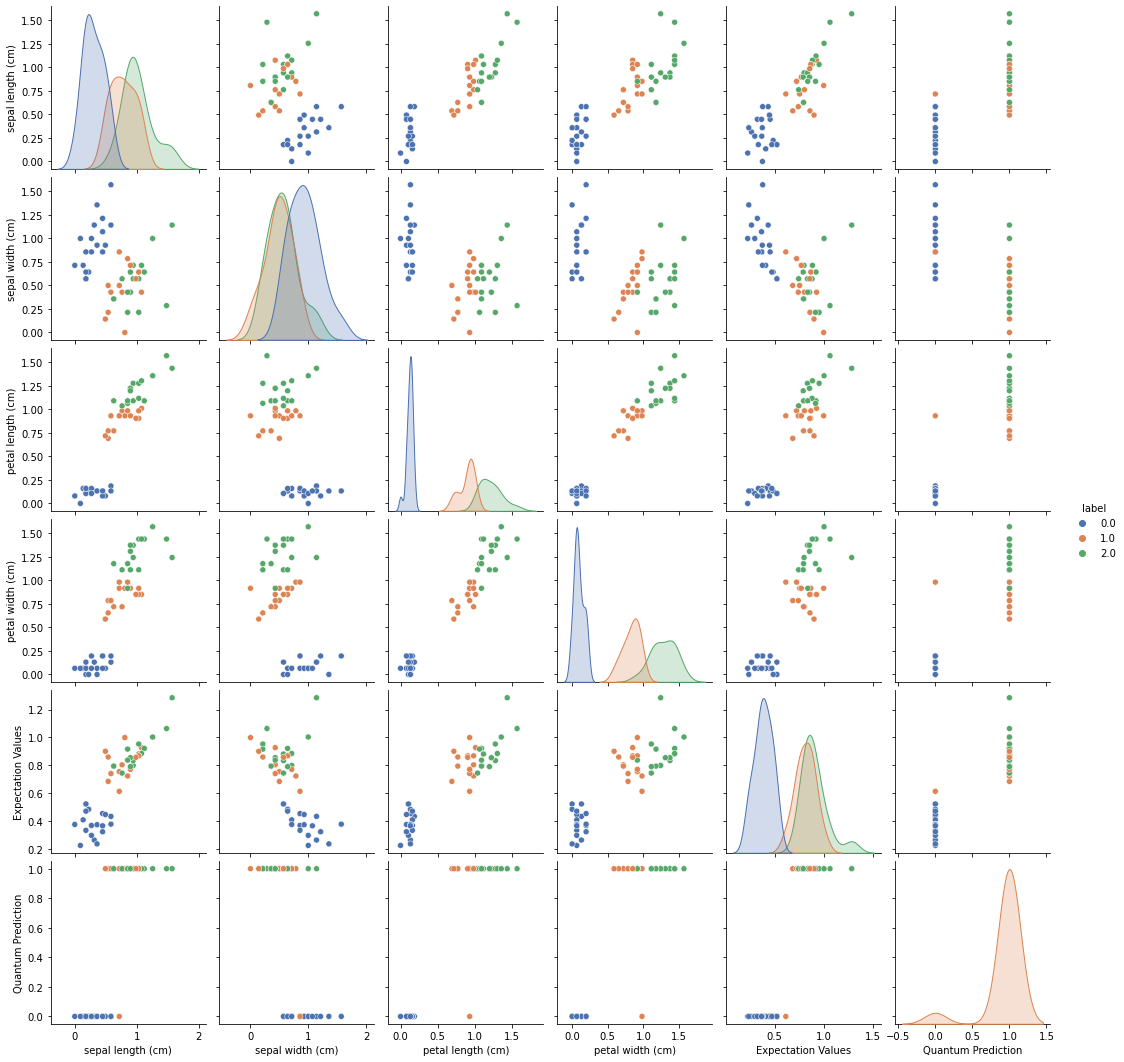

In [ ]:
sns.pairplot(test_df, hue="label", palette = 'deep')

Generate shadded boundary values by generating and fitting a model

## Feature space landscape and local Interpretability of solution

Stop using pandas, its shit.

CPU/GPU kernel for classification

In [ ]:
import numba
from numba import jit, njit

In [ ]:
N = 5
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
feature_space.columns = features[0:4]

In [ ]:
feature_space

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.392699
2,0.000000,0.000000,0.000000,0.785398
3,0.000000,0.000000,0.000000,1.178097
4,0.000000,0.000000,0.000000,1.570796
...,...,...,...,...
620,1.570796,1.570796,1.570796,0.000000
621,1.570796,1.570796,1.570796,0.392699
622,1.570796,1.570796,1.570796,0.785398
623,1.570796,1.570796,1.570796,1.178097


Make predictions on the feature space mesh grid

In [ ]:
"""fs_pred = np.zeros(len(feature_space))

"""
def get_fs_pred():
  fs_exp = np.zeros(len(feature_space))
  fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
    fs_exp[i] = get_expectation(feature_space.iloc[i][0:4],U_dom, theta)
    fs_pred[i] = classify_tri(fs_exp[i])

  return fs_pred, fs_exp

  
pred, exp = get_fs_pred()
feature_space.insert(4,'Expectation Values', exp)
feature_space.insert(5,'Quantum Prediction', pred)

In [ ]:
feature_space.reindex(np.random.permutation(feature_space.index)).head(40300)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation Values,Quantum Prediction
342,1.178097,0.785398,1.178097,0.785398,0.947300,1.0
398,0.000000,1.178097,1.570796,1.178097,0.122102,0.0
312,0.785398,0.785398,0.785398,0.785398,0.681173,1.0
406,0.392699,1.178097,0.392699,0.392699,0.299583,0.0
516,0.000000,1.570796,1.178097,0.392699,0.050194,0.0
...,...,...,...,...,...,...
346,1.178097,0.785398,1.570796,0.392699,0.947300,1.0
7,0.000000,0.000000,0.392699,0.785398,0.998976,1.0
308,0.785398,0.785398,0.392699,1.178097,0.681173,1.0
620,1.570796,1.570796,1.570796,0.000000,1.312839,1.0


In [ ]:
feature_space['Expectation Values']

0      0.998976
1      0.998976
2      0.998976
3      0.998976
4      0.998976
         ...   
620    1.312839
621    1.312839
622    1.312839
623    1.312839
624    1.312839
Name: Expectation Values, Length: 625, dtype: float64

In [ ]:
#feature_space = feature_space[feature_space['Quantum Prediction'] != 2]

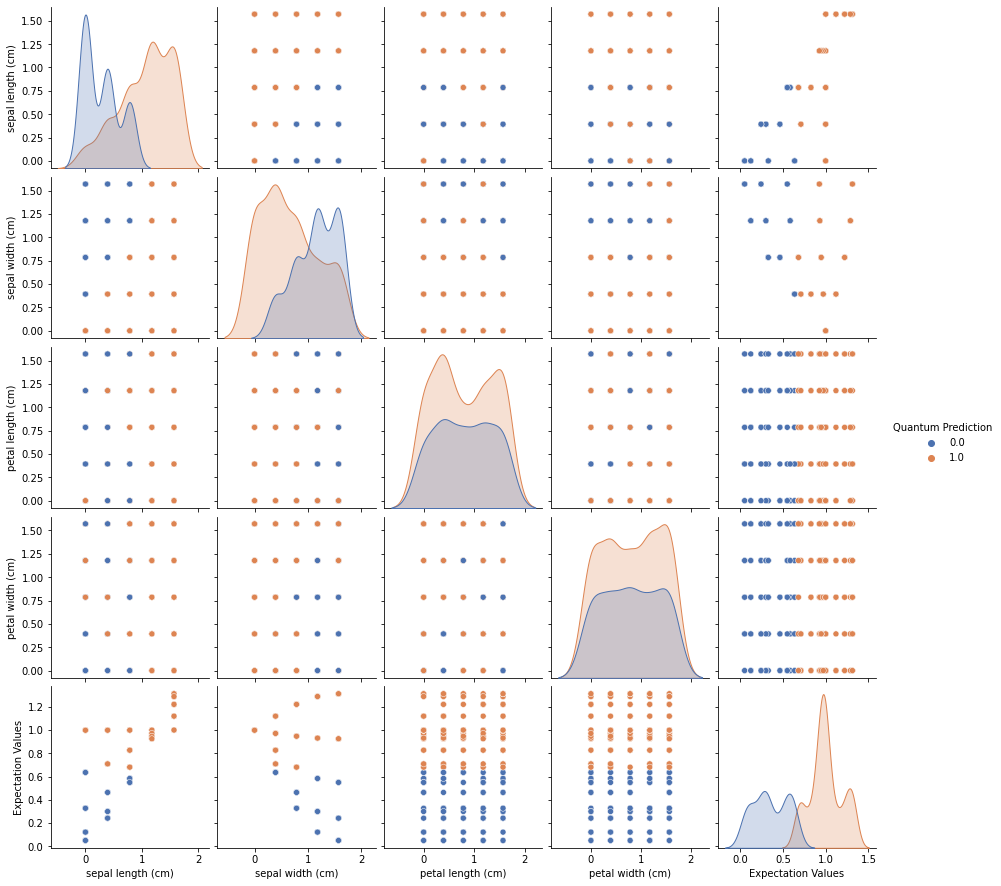

In [ ]:
sns.pairplot(feature_space.sample(300), hue = 'Quantum Prediction', palette = 'deep')

# Binary Classification 

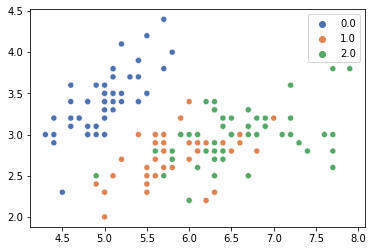

In [ ]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

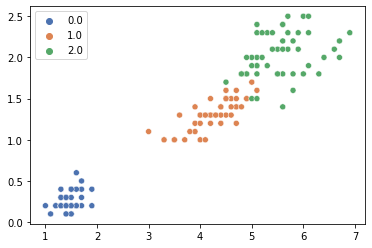

In [ ]:
sns.scatterplot(data=data, x=data[:,2], y=data[:,3], hue=data[:,4], palette="deep")

## Convert and visualise data

The embedding and computational circuits will be unchanged.

In [ ]:
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(X_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1


In [ ]:
X_test_bi[1]

array([1.3, 1.6, 0.7, 0.2])

In [ ]:
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

In [ ]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

for i in range(len(y_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train_bi)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1

train_data_bi = np.zeros((X_train_bi.shape[0], X_train_bi.shape[1] + 1))
train_data_bi[:,0:4] = X_train_bi
train_data_bi[:,4] = y_train_bi
train_df_bi = pd.DataFrame(data = train_data_bi, columns = features)

test_data_bi = np.zeros((X_test_bi.shape[0], X_test_bi.shape[1] + 1))
test_data_bi[:,0:4] = X_test_bi
test_data_bi[:,4] = y_test_bi
test_df_bi = pd.DataFrame(data = test_data_bi, columns = features)

In [ ]:
train_df_bi[train_df_bi.columns[:4]] -= train_df_bi[train_df_bi.columns[:4]].min()
train_df_bi[train_df_bi.columns[:4]] /= train_df_bi[train_df_bi.columns[:4]].max()
train_df_bi[train_df_bi.columns[:4]] *= np.pi/2

In [ ]:
test_df_bi[test_df_bi.columns[:4]] -= test_df_bi[test_df_bi.columns[:4]].min()
test_df_bi[test_df_bi.columns[:4]] /= test_df_bi[test_df_bi.columns[:4]].max()
test_df_bi[test_df_bi.columns[:4]] *= np.pi/2

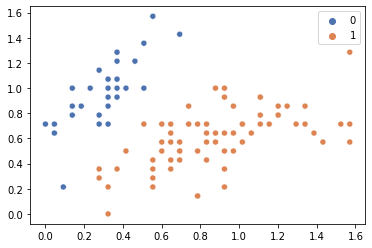

In [ ]:
sns.scatterplot(data=normed_train_data_bi, x=normed_train_data_bi[:,0], y=normed_train_data_bi[:,1], hue=y_train_bi, palette="deep")

In [ ]:
features

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)',
 'label']

In [ ]:
#sns.pairplot(train_df_bi, hue="label", palette = 'deep')

In [ ]:
y_train, expectations

(array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]),
 array([0.80415938, 0.43544087, 1.06402976, 0.75536806, 0.92729797,
        0.45534477, 0.68551788, 0.92183354, 0.99953603, 0.79513832,
        0.79989467, 0.52415144, 0.44866298, 0.48605212, 0.26588754,
        0.72440978, 0.83472524, 0.86009997, 0.7416929 , 0.85525805,
        0.41040584, 0.74529747, 0.37036368, 0.85525805, 1.28470863,
        0.8816186 , 0.95330328, 0.88552012, 0.52415144, 0.47266687,
        0.22724525, 0.37965986, 0.86881028, 0.33531583, 0.37723561,
        0.91683308, 0.77208282, 0.37562079, 0.29929694, 0.23831396,
        0.79513832, 0.61462933, 0.86881028, 0.32511607, 0.36769079,
        0.90133155, 0.83788724, 0.79138707, 0.

In [ ]:
def get_expectation_bi(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)
  print(exp)
  exp = (exp + 1)/2
  

  return exp

In [ ]:
#Binary cost function:
def bi_cost_train(theta):
  #get expectations
  expectations = np.zeros(len(train_df_bi))
  for i in range(len(train_df_bi)):
    expectations[i] = get_expectation_bi(train_df_bi.iloc[i][0:4],U_dom, theta)
  #Simple MSE example
  
  #predictions are currently expectation values
  L = ((expectations - y_train)**2).mean()
  #print(L)
  #print(expectations)
  return L

In [ ]:
#Define the binary VQC and set initial values of theta
bi_circuit = U_dom()
theta_0 = np.random.rand(7)
for i in range(bi_circuit.get_parameter_count()):
  bi_circuit.set_parameter(i,theta_0[i])

parameter_count = bi_circuit.get_parameter_count()
param = [bi_circuit.get_parameter(ind) for ind in range(parameter_count)]
param

[0.6220323648362143,
 0.428051001110642,
 0.6269366738274876,
 0.8083943337875533,
 0.25345218678284487,
 0.14163972006672743,
 0.8947343726259149]

In [ ]:
#Define the pauli matrix for which the expectation will be taken.
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [ ]:
x = train_df_bi.iloc[0][0:4]
xp = get_expectation_bi(x,U_dom,theta)

-0.34170754413283916


In [ ]:
#Classify and expectation value that is reshaped to be between 0 and 1.
def classify_bi(exp):
  if exp >= 0.5:
    pred = 1
  else:
    pred = 0
  return pred

In [ ]:
bi_expectation = []
for i in range(len(train_df_bi)):
  bi_expectation.append(get_expectation_bi(train_df_bi.iloc[i][0:4],U_dom,np.random.rand(7)))
train_df_bi.insert(4,'Test Binary Expectation', bi_expectation)

-0.7670213407322547
-0.05704532987801868
-0.8330564123929829
-0.9190878919470041
0.10570447495683122
-0.895601707315895
-0.3011662546642343
-0.4813638205788615
-0.6825487789570214
-0.5308712106902521
-0.9198584703171164
-0.2686237525676144
-0.4714249548621653
-0.8541124382386092
-0.7472169779138461
-0.9248595288933543
-0.9428854769140088
-0.004734511050584676
-0.4822433300316395
-0.6810478455086187
-0.9965713445000445
-0.1657054460016547
-0.7317213485171984
-0.9915143554644595
-0.982823578440779
-0.6483976481803422
-0.8667684893491856
-0.6515713512618054
-0.1783979619547158
-0.6239554030545806
-0.8018776471894808
-0.6170769942236533
-0.46943618552759253
-0.923151439684549
-0.18967473901275678
-0.8885751805321583
-0.895217359710221
-0.2769568757367387
-0.7476622101758991
-0.6222009750022407
-0.842353943105031
-0.11713912359939815
-0.8446447692760856
-0.9748471171884211
0.165982224245235
-0.8232335352985846
-0.333508537543441
-0.40592032295268327
-0.6098860299495594
0.07008498333680287
-

In [ ]:
#find number of correct predictions
correct = 0
for i in range(len(train_df_bi)):
  if train_df_bi['label'][i] == classify_bi(train_df_bi['Test Binary Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')

The initial calssification is 34.0 % accurate


In [ ]:
train_df_bi['Binary Expectation'] = bi_expectation

In [ ]:
train_df_bi

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Test Binary Expectation,label,Binary Expectation
0,5.7,2.9,4.2,1.3,0.116489,1.0,0.116489
1,7.6,3.0,6.6,2.1,0.471477,1.0,0.471477
2,5.6,3.0,4.5,1.5,0.083472,1.0,0.083472
3,5.1,3.5,1.4,0.2,0.040456,0.0,0.040456
4,7.7,2.8,6.7,2.0,0.552852,1.0,0.552852
...,...,...,...,...,...,...,...
95,6.1,2.8,4.0,1.3,0.021272,1.0,0.021272
96,4.9,2.5,4.5,1.7,0.368103,1.0,0.368103
97,5.8,4.0,1.2,0.2,0.560379,0.0,0.560379
98,5.8,2.6,4.0,1.2,0.033266,1.0,0.033266


## Optimise

In [ ]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(7)
result = minimize(bi_cost_train, theta_0, method='cobyla')
theta = result.x

In [ ]:
def bi_cost_test(theta):
  #get predictions
  predictions_bi = np.zeros(len(test_df_bi))
  for i in range(len(test_df_bi)):
    predictions_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_dom,theta)
  #Simple MSE example
  L = ((predictions_bi - y_test)**2).mean()
  return L

In [ ]:
theta, theta_0

(array([2.62203027, 0.20762648, 0.0128346 , 0.08467637, 0.37248261,
        0.32024862, 0.55906853]),
 array([0.45639635, 0.01721085, 0.16717348, 0.1839534 , 0.68941592,
        0.5838756 , 0.64375711]))

In [ ]:
bi_cost_test(theta),bi_cost_test(theta_0)

In [ ]:
bi_better_predictions = np.zeros(len(test_df_bi))
expectation_bi = np.zeros(len(test_df_bi))
for i in range(len(test_df_bi)):
  bi_better_predictions[i] = classify_bi(get_expectation_bi(test_df_bi.iloc[i][0:4],U_dom, theta))
  expectation_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_dom, theta)

test_df_bi.insert(4,'Expectation Values', expectation_bi)
test_df_bi.insert(5,'Quantum Prediction', bi_better_predictions)

In [ ]:
test_df_bi.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation Values,Quantum Prediction,label
0,0.762958,0.428399,0.985076,0.719948,0.402086,0.0,1.0
1,0.583439,1.142397,0.186366,0.130900,0.217719,0.0,0.0
2,1.481037,0.285599,1.570796,1.439897,0.532006,1.0,1.0
3,0.718078,0.499799,0.931828,0.916298,0.377691,0.0,1.0
4,1.077117,0.428399,1.011699,0.850848,0.463648,0.0,1.0


In [ ]:
correct = 0
for i in range(len(test_df_bi)):
  if test_df_bi.iloc[i][5] == test_df_bi.iloc[i][6]:
    correct += 1 

print('The final classification is',(correct/len(test_df_bi)) * 100, '% accurate')

The final classification is 88.0 % accurate


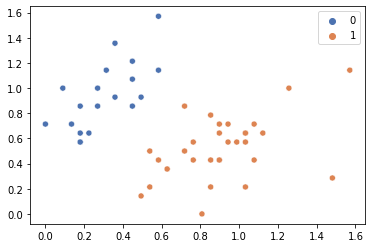

In [ ]:
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

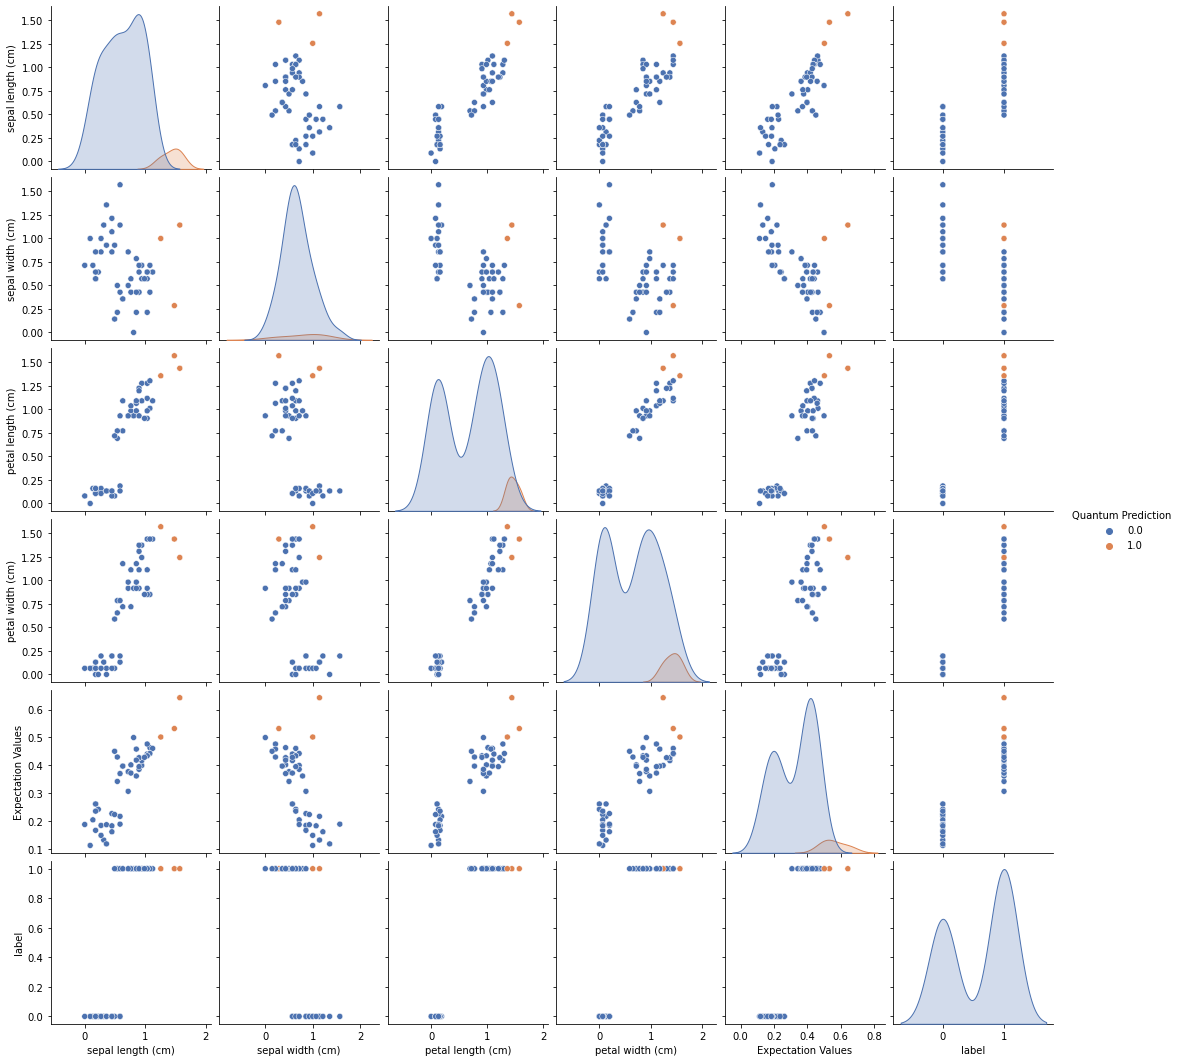

In [ ]:
sns.pairplot(test_df_bi, hue="Quantum Prediction", palette = 'deep')

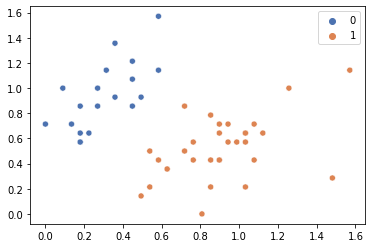

In [ ]:
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

## Feature space landscape and local interpretability of solution

In [ ]:
bi_feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
bi_feature_space.columns = features[0:4]

In [ ]:
def get_bi_fs_pred():
  bi_fs_exp = np.zeros(len(feature_space))
  bi_fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(bi_feature_space.iloc[i][0:4],U_dom, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
bi_pred, bi_exp = get_bi_fs_pred()
bi_feature_space.insert(4,'Expectation Values', bi_exp)
bi_feature_space.insert(5,'Quantum Prediction', bi_pred)

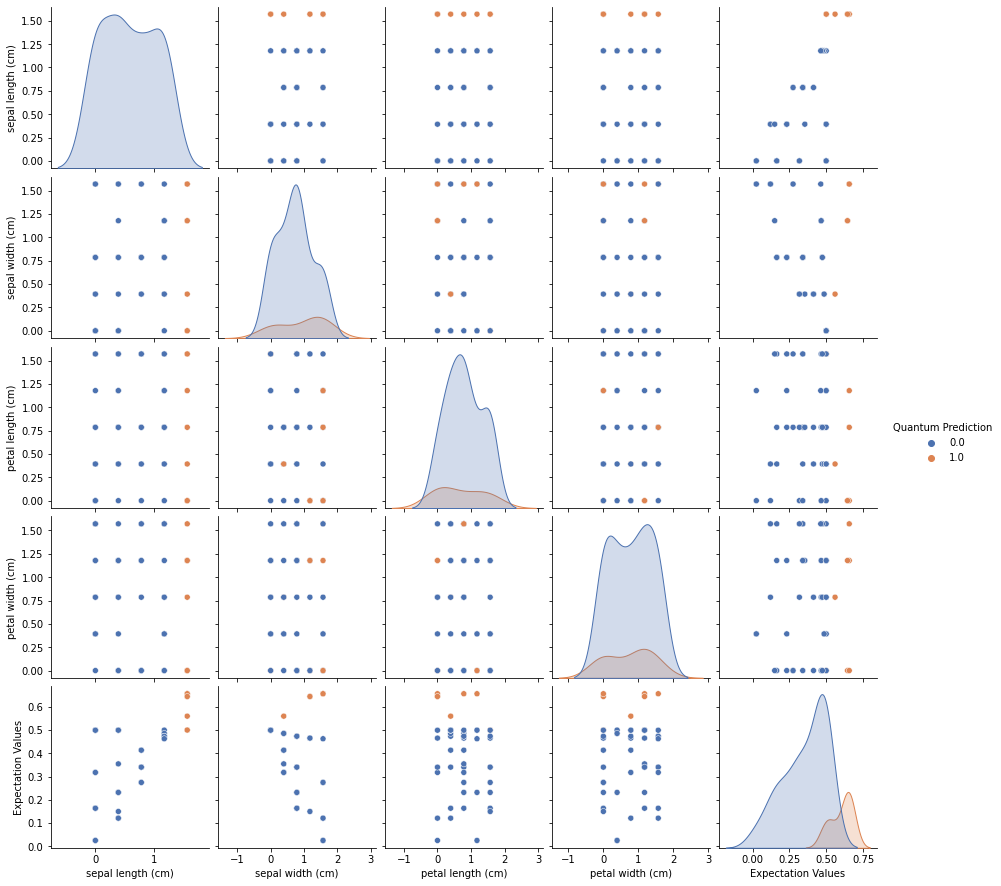

In [ ]:
sns.pairplot(bi_feature_space.sample(50), hue = 'Quantum Prediction', palette = 'deep')

# Classical model + LIME

In [ ]:
pip install lime

In [ ]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
#from __future__ import print_function
np.random.seed(1)

## Train random forest classifier

In [ ]:
train_df.head(), test_df.head()

(   sepal length (cm)  sepal width (cm)  ...  Expectation  label
 0           0.646798          0.642598  ...     1.252191    1.0
 1           1.524596          0.713998  ...     1.052176    2.0
 2           0.600599          0.713998  ...     0.990845    1.0
 3           0.369599          1.070997  ...     1.052849    0.0
 4           1.570796          0.571199  ...     0.595096    2.0
 
 [5 rows x 6 columns],
    sepal length (cm)  sepal width (cm)  ...  Quantum Prediction  label
 0           0.762958          0.428399  ...                 1.0    1.0
 1           0.583439          1.142397  ...                 1.0    0.0
 2           1.481037          0.285599  ...                 2.0    2.0
 3           0.718078          0.499799  ...                 1.0    1.0
 4           1.077117          0.428399  ...                 2.0    1.0
 
 [5 rows x 7 columns])

In [ ]:
#training data features
train_df[train_df.columns[:6]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation,label
0,0.646798,0.642598,0.869548,0.785398,1.252191,1.0
1,1.524596,0.713998,1.542746,1.308997,1.052176,2.0
2,0.600599,0.713998,0.953698,0.916298,0.990845,1.0
3,0.369599,1.070997,0.084150,0.065450,1.052849,0.0
4,1.570796,0.571199,1.570796,1.243547,0.595096,2.0
...,...,...,...,...,...,...
95,0.831598,0.571199,0.813448,0.785398,1.023265,1.0
96,0.277199,0.356999,0.953698,1.047198,1.436930,2.0
97,0.692998,1.427997,0.028050,0.065450,0.846314,0.0
98,0.692998,0.428399,0.813448,0.719948,1.026907,1.0


In [ ]:
#training data labels
train_df[train_df.columns[5]]

0     1.0
1     2.0
2     1.0
3     0.0
4     2.0
     ... 
95    1.0
96    2.0
97    0.0
98    1.0
99    2.0
Name: label, Length: 100, dtype: float64

In [ ]:
#Call model from sklearn
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_df[train_df.columns[:4]], train_df[train_df.columns[5]])

RandomForestClassifier(n_estimators=500)

In [ ]:
#test data features
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation Values,Quantum Prediction,label
0,0.762958,0.428399,0.985076,0.719948,1.078719,1.0,1.0
1,0.583439,1.142397,0.186366,0.130900,0.912152,1.0,0.0
2,1.481037,0.285599,1.570796,1.439897,1.583162,2.0,2.0
3,0.718078,0.499799,0.931828,0.916298,1.040568,1.0,1.0
4,1.077117,0.428399,1.011699,0.850848,1.346637,2.0,1.0


In [ ]:
classical_predictions = rf.predict(test_df[test_df.columns[:4]])

In [ ]:
classical_predictions

array([1., 0., 2., 1., 1., 0., 1., 2., 1., 1., 2., 0., 0., 0., 0., 1., 2.,
       1., 1., 2., 0., 2., 0., 2., 2., 2., 2., 2., 0., 0., 0., 0., 1., 0.,
       0., 2., 1., 0., 0., 0., 2., 1., 1., 0., 0., 1., 1., 2., 1., 2.])

In [ ]:
test_df.insert(6,'Classical Prediction', classical_predictions)

In [ ]:
correct = 0
for i in range(len(test_df['label'])): 
  if test_df['label'][i] == test_df['Classical Prediction'][i]:
    correct += 1
percent_correct = correct*100/len(test_df)
print('The percentage of correct assignments for the classical random forest is ', percent_correct, '%')

The percentage of correct assignments for the classical random forest is  98.0 %


In [ ]:
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation,label
0,0.646798,0.642598,0.869548,0.785398,1.252191,1.0
1,1.524596,0.713998,1.542746,1.308997,1.052176,2.0
2,0.600599,0.713998,0.953698,0.916298,0.990845,1.0
3,0.369599,1.070997,0.084150,0.065450,1.052849,0.0
4,1.570796,0.571199,1.570796,1.243547,0.595096,2.0


## Create the explainer

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_df.iloc[:,:4].values, feature_names=train_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)

In [ ]:
i = np.random.randint(0, test_df.shape[0])
exp = explainer.explain_instance(test_df.iloc[:,:4].values[7], rf.predict_proba, num_features=2, top_labels=3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
exp.show_in_notebook(show_table=True, show_all=True)

In [ ]:
test_df.iloc[i]

sepal length (cm)       0.134640
sepal width (cm)        0.713998
petal length (cm)       0.159742
petal width (cm)        0.065450
Expectation Values      0.497222
Quantum Prediction      0.000000
Classical Prediction    0.000000
label                   0.000000
Name: 20, dtype: float64

# LIME using a VQC as the explained classifier.


Sample around a certain point (Done)

Calculate the distance between the sampled instances and the instance being explained (Done)

For these synthetically generated instances, make predictions using the original global model (Done)

Fit a simple linear model on this data set

This linear model is weighted based on the similarity index calculated in step 2. 

This is to ensure that the errors on the instances most closest to the original instance are valued more than others

In [ ]:
#Takes a 4d vector and returns a series of points in the local area.
#I assume the point x is in the domain [0,pi/2]
def sample_about_point(x,R,N):
  #N is the number of points over the axis that is considered

  #Consider a hypersquare with the point at the center of side length R
  start_w = max(0,x[0] - R)
  end_w = min(x[0] + R, np.pi/2)
  start_x = max(0,x[1] - R)
  end_x = min(x[1] + R, np.pi/2)
  start_y = max(0,x[2] - R)
  end_y = min(x[2] + R, np.pi/2)
  start_z = max(0,x[3] - R)
  end_z = min(x[3] + R, np.pi/2)

  w = np.linspace(start_w,end_w,N, endpoint = True)
  x = np.linspace(start_x,end_x,N, endpoint = True)
  y = np.linspace(start_y,end_y,N, endpoint = True)
  z = np.linspace(start_z,end_z,N, endpoint = True)

  ww, xx, yy, zz = np.meshgrid(w,x,y,z)

  w_flat = ww.reshape(N**4)
  x_flat = xx.reshape(N**4)
  y_flat = yy.reshape(N**4)
  z_flat = zz.reshape(N**4)
  fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

  feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
  feature_space.columns = features[0:4]
  return feature_space


In [ ]:
x = np.array([0.600599,	0.713998,	0.953698,	0.916298]) 
R = 0.5
N = 5
sample_data = sample_about_point(x,R,N)

In [ ]:
def get_bi_fs_pred():
  bi_fs_exp = np.zeros(len(feature_space))
  bi_fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(bi_feature_space.iloc[i][0:4],U_dom, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
bi_pred, bi_exp = get_bi_fs_pred()
bi_feature_space.insert(4,'Expectation Values', bi_exp)
bi_feature_space.insert(5,'Quantum Prediction', bi_pred)

In [ ]:
def lime_get_bi_fs_pred(sample_data):
  bi_fs_exp = np.zeros(len(sample_data))
  bi_fs_pred = np.zeros(len(sample_data))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(sample_data.iloc[i][0:4],U_dom, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
lime_bi_pred, lime_bi_exp = lime_get_bi_fs_pred(sample_data)

sample_data.insert(4,'Expectation Values', lime_bi_exp)
sample_data.insert(5,'Quantum Prediction', lime_bi_pred)

In [ ]:
a = np.array(sample_df.iloc[:][:]).max()

In [ ]:
a

1.5707963267948966

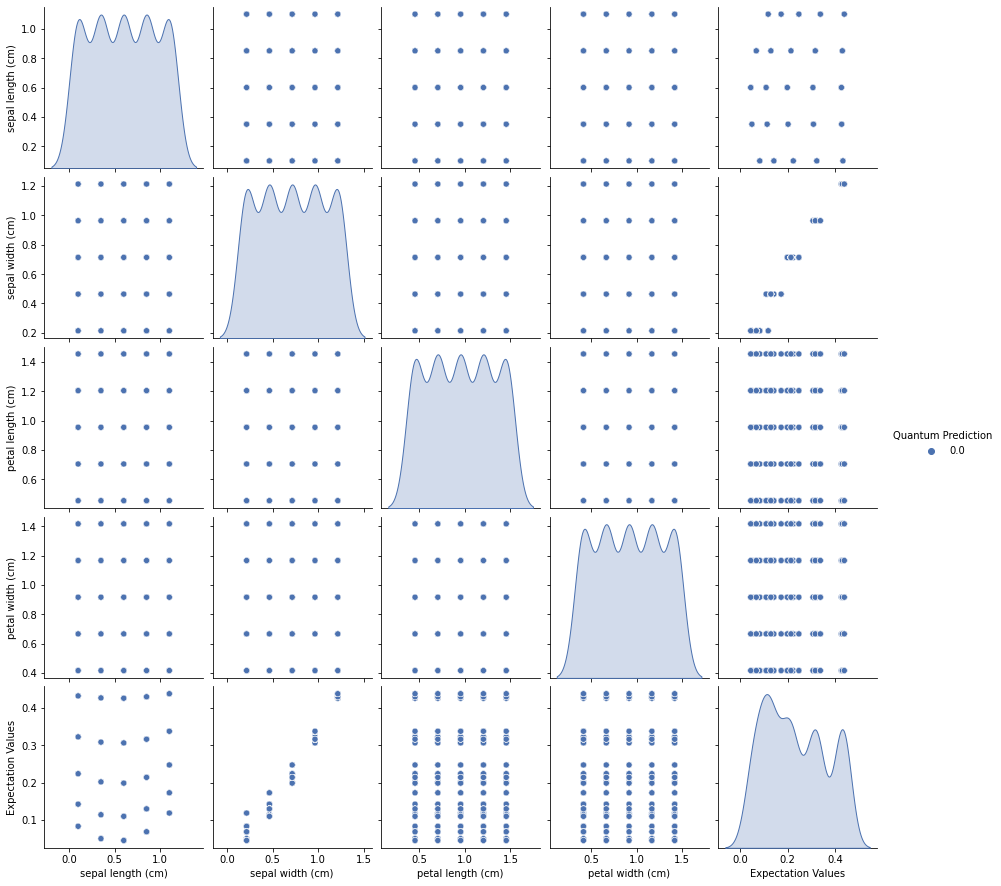

In [ ]:
sample_df = pd.DataFrame(sample_data)
sns.pairplot(sample_df, palette = 'deep', hue = 'Quantum Prediction')

In [ ]:
#find the value of the projector pi_x(z)
def pi_x(x,z):
  #x is the point of interest
  #z is an array of local sample points, not that dataframes must be converted 
  #to numpy arrays.
  #returns projective weights
  projected_weights = np.zeros(z.shape[0])
  for i in range(z.shape[0]):
    projected_weights[i] = np.exp(-(np.linalg.norm(x-z[i])))

  #Using exponential decay kernel
  return projected_weights

In [ ]:
sample_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Expectation Values,Quantum Prediction
0,0.100599,0.213998,0.453698,0.416298,0.083245,0.0
1,0.100599,0.213998,0.453698,0.666298,0.083245,0.0
2,0.100599,0.213998,0.453698,0.916298,0.083245,0.0
3,0.100599,0.213998,0.453698,1.166298,0.083245,0.0
4,0.100599,0.213998,0.453698,1.416298,0.083245,0.0
...,...,...,...,...,...,...
620,1.100599,1.213998,1.453698,0.416298,0.437885,0.0
621,1.100599,1.213998,1.453698,0.666298,0.437885,0.0
622,1.100599,1.213998,1.453698,0.916298,0.437885,0.0
623,1.100599,1.213998,1.453698,1.166298,0.437885,0.0


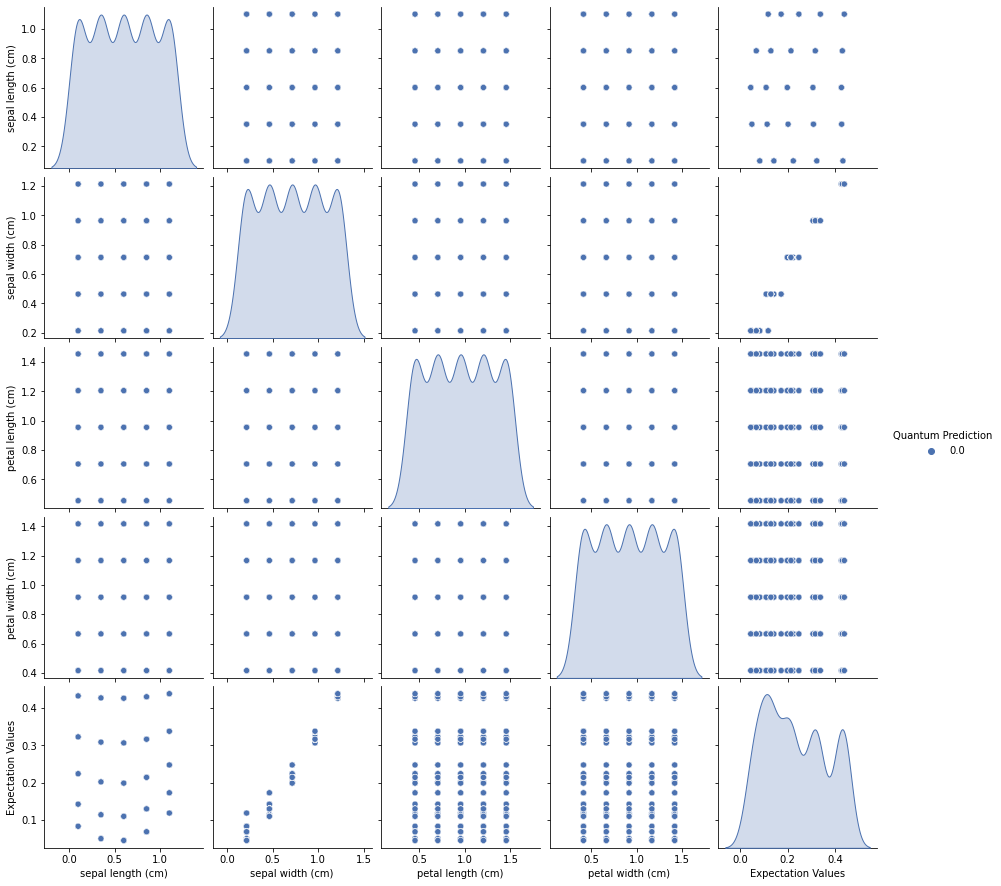

In [ ]:
sns.pairplot(sample_data, hue = 'Quantum Prediction', palette = 'deep')